In [5]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline  
%config InlineBackend.figure_format='retina'  
plt.rc('font', family='Malgun Gothic') # 윈도우즈
plt.rc('axes', unicode_minus=False)  # 축의 - 깨짐 방지
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
import tensorflow as tf
import os

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.list_logical_devices('GPU')
    print("GPU 메모리 성장(Memory Growth) 설정을 완료했습니다.")

  except RuntimeError as e:
    print("❌ 런타임 오류:", e)
else:
  print("⚠️ 경고: 사용 가능한 GPU를 찾을 수 없습니다. CPU로 훈련을 진행합니다.")
  print("CUDA와 cuDNN 설치, 그리고 그래픽 드라이버 버전을 확인해주세요.")


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

❌ 런타임 오류: Physical devices cannot be modified after being initialized


# 데이터 전처리

In [2]:
import pandas as pd
import numpy as np

item = '무'
item_code = 1101
df_path = f'datasets/작물_lag_월단위_스케일링X_인코딩X/{item}_월차낼게요.csv'
external_path = 'datasets/factor_external_weekly_ver_0721.csv'
save_path = f'datasets/작물_lag_월단위_스케일링X_인코딩X/{item}_월차_집계가공.csv'  # 중간저장

In [3]:
try:
    df = pd.read_csv(df_path, encoding='cp949')
except FileNotFoundError:
    print(f"❌ 오류: {df_path} 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()
    
print(f"➡️ 데이터를 불러왔습니다. (결과: {len(df)}행)")

df_processed = df.drop(columns=['등급코드'])
print("➡️ '등급코드' 컬럼을 제외했습니다.")

group_keys = ['year', 'week', '품종코드', '직팜산지코드']
agg_rules = {
    '평균단가(원)': 'mean',
    '총거래량(kg)': 'sum',
    '일평균기온_t-1': 'mean', '일평균기온_t-2': 'mean', '일평균기온_t-3': 'mean',
    '강수량(mm)_t-1': 'mean', '강수량(mm)_t-2': 'mean', '강수량(mm)_t-3': 'mean',
    '최고기온_t-1': 'mean', '최고기온_t-2': 'mean', '최고기온_t-3': 'mean',
    '최저기온_t-1': 'mean', '최저기온_t-2': 'mean', '최저기온_t-3': 'mean',
    '1시간최고강수량(mm)_t-1': 'mean', '1시간최고강수량(mm)_t-2': 'mean', '1시간최고강수량(mm)_t-3': 'mean',
    '평균상대습도_t-1': 'mean', '평균상대습도_t-2': 'mean', '평균상대습도_t-3': 'mean'
}

df_agg = df_processed.groupby(group_keys).agg(agg_rules).reset_index()
df_agg.drop_duplicates(inplace=True)
print(f"➡️ 데이터를 주간 단위로 그룹화했습니다. (결과: {len(df_agg)}행)")

df_grow = pd.read_csv(external_path, encoding='utf-8')

def format_week_int(weekno):
    year = weekno // 100
    week = weekno % 100
    return year, week

df_grow[['year', 'week']] = df_grow['weekno'].apply(
    lambda x: pd.Series(format_week_int(x))
)
df_grow.drop(columns='weekno', inplace=True)
             
df_agg['item_code']=item_code
             
df_agg.drop(columns=['holiday_flag', 'holiday_score', 'grow_score'], inplace=True, errors='ignore')
df_agg  = pd.merge( df_agg,
                    df_grow[['year', 'week', 'item_code', 'holiday_flag', 'holiday_score', 'grow_score']],
                    left_on=['year', 'week', 'item_code'],
                    right_on=['year', 'week', 'item_code'],
                    how='left'
                )
df = df_agg.drop(columns='item_code')

df.to_csv(save_path, index=False)
df.head()

✅ 원본 데이터를 성공적으로 불러왔습니다.
➡️ 데이터를 불러왔습니다. (결과: 86942행)
➡️ '등급코드' 컬럼을 제외했습니다.
➡️ 데이터를 주간 단위로 그룹화했습니다. (결과: 44464행)


,year,week,품종코드,직팜산지코드,평균단가(원),총거래량(kg),일평균기온_t-1,일평균기온_t-2,일평균기온_t-3,강수량(mm)_t-1,...,최저기온_t-3,1시간최고강수량(mm)_t-1,1시간최고강수량(mm)_t-2,1시간최고강수량(mm)_t-3,평균상대습도_t-1,평균상대습도_t-2,평균상대습도_t-3,holiday_flag,holiday_score,grow_score
0,2018,13,1,1036,805.0,680.0,6.081250,-1.212500,-3.337500,8.9750,...,-8.2500,0.0,0.0,0.0,66.312500,48.787500,60.800000,2,0.0,6
1,2018,13,1,1079,300.0,20.0,8.862500,0.591667,-0.630000,16.3750,...,-6.0750,0.0,0.0,0.0,68.008333,58.016667,65.925000,2,0.0,6
2,2018,13,1,1136,496.0,53020.0,9.491667,4.665179,5.892917,14.9625,...,1.6625,0.0,0.0,0.0,66.296667,61.265179,70.005833,2,0.0,6
3,2018,13,1,1137,700.0,147660.0,11.537500,4.300000,6.440675,34.4750,...,1.2500,0.0,0.0,0.0,81.933333,58.416667,73.269544,2,0.0,6
4,2018,13,1,1170,447.5,153820.0,9.548438,3.818271,4.607292,34.0375,...,0.3875,0.0,0.0,0.0,71.450521,57.386339,68.486979,2,0.0,6


# 프로펫 + LSTM 모델 - Robust

In [12]:
item = '무'
item_code = 1101
df_path = f'datasets/작물_lag_월단위_스케일링X_인코딩X/{item}_월차낼게요.csv'
external_path = 'datasets/factor_external_weekly_ver_0721.csv'
save_path = f'datasets/작물_lag_월단위_스케일링X_인코딩X/{item}_월차_집계가공.csv'  # 중간저장 
model_path = 'final_model_checkpoints'


if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists('datasets'):
    os.makedirs('datasets')
    
    
    LSTM(units=128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [29]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

item = item
TARGET_COL = '평균단가(원)'
TIMESTEPS = 8
file_path = save_path
LSTM_UNITS = 128
activation='relu'
epochs = 100
batch_size = 64
stop_patience = 40

df = pd.read_csv(file_path)

group_cols = ['직팜산지코드', '품종코드']
ts_feature_names = ['가격변화율', '가격차분']
df['가격변화율'] = df.groupby(group_cols)[TARGET_COL].pct_change().shift(1)
df['가격차분'] = df.groupby(group_cols)[TARGET_COL].diff().shift(1)

df[ts_feature_names] = df.groupby(group_cols)[ts_feature_names].fillna(0)
df.replace([np.inf, -np.inf], 0, inplace=True)

df['price_volume'] = df['평균단가(원)'] * df['총거래량(kg)']
agg_rules = {col: 'mean' for col in ts_feature_names}
agg_rules['price_volume'] = 'sum'
agg_rules['총거래량(kg)'] = 'sum'

df_agg = df.groupby(['year', 'week']).agg(agg_rules).reset_index()
df_agg[TARGET_COL] = df_agg['price_volume'] / df_agg['총거래량(kg)']
df_agg.drop(columns=['price_volume'], inplace=True)

df_prophet = df_agg.copy()
df_prophet['ds'] = pd.to_datetime(df_agg['year'].astype(str) + df_agg['week'].astype(str) + '0', format='%Y%W%w')
df_prophet['y_original'] = df_agg[TARGET_COL]
df_prophet['y'] = np.log1p(df_agg[TARGET_COL])

train_prophet_df = df_prophet[df_prophet['ds'].dt.year < 2025].copy()
regressor_cols = [col for col in agg_rules.keys() if col not in ['price_volume', '총거래량(kg)']]

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for col in regressor_cols:
    prophet_model.add_regressor(col)
prophet_model.fit(train_prophet_df[['ds', 'y'] + regressor_cols])

forecast = prophet_model.predict(df_prophet[['ds'] + regressor_cols])

df_prophet['prophet_pred'] = forecast['yhat'].values
df_prophet['residual'] = df_prophet['y'] - df_prophet['prophet_pred']

lstm_feature_cols = ['residual'] + regressor_cols
lstm_target_col = 'residual'

cutoff_date = pd.to_datetime('2024-40-0', format='%Y-%W-%w')

train_final_df = df_prophet[df_prophet['ds'] <= cutoff_date].copy()
test_final_df = df_prophet[df_prophet['ds'] > cutoff_date].copy()

scaler = RobustScaler()
train_final_df[lstm_feature_cols] = scaler.fit_transform(train_final_df[lstm_feature_cols])
test_final_df[lstm_feature_cols] = scaler.transform(test_final_df[lstm_feature_cols])

def create_multivariate_sequences(df, feature_cols, target_col, timesteps):
    X, y = [], []
    features = df[feature_cols].values
    target = df[target_col].values
    for i in range(len(df) - timesteps):
        X.append(features[i:(i + timesteps)])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_multivariate_sequences(train_final_df, lstm_feature_cols, lstm_target_col, TIMESTEPS)
X_test_seq, y_test_seq = create_multivariate_sequences(test_final_df, lstm_feature_cols, lstm_target_col, TIMESTEPS)

lstm_model = Sequential([
    LSTM(units=LSTM_UNITS, activation=activation, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
print("\n🔥 LSTM으로 잔차 학습 시작...")

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_filepath = os.path.join(model_path, f'best_model_LSTM+Prophet_{item}_{current_time}.keras')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=stop_patience, restore_best_weights=True, verbose=1) # Patience 조정
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)


history = lstm_model.fit(X_train_seq, y_train_seq, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data=(X_test_seq, y_test_seq), 
                         verbose=1,
                         callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
                        )

14:06:37 - cmdstanpy - INFO - Chain [1] start processing


✅ 원본 데이터 로드 완료 (Shape: (44464, 27))
✅ 그룹별 시계열 피처 생성 및 정제 완료


14:06:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet 모델 학습 완료
✅ 전체 기간에 대한 Prophet 예측 및 잔차 계산 완료

🔥 LSTM으로 잔차 학습 시작...
Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6151 - mse: 0.6151
Epoch 1: val_loss improved from inf to 1.47368, saving model to final_model_checkpoints\best_model_LSTM+Prophet_무_20250725_140637.keras
6/6 [==============================] - 1s 70ms/step - loss: 0.6124 - mse: 0.6124 - val_loss: 1.4737 - val_mse: 1.4737 - lr: 0.0010
Epoch 2/100
4/6 [===================>..........] - ETA: 0s - loss: 0.4342 - mse: 0.4342
Epoch 2: val_loss improved from 1.47368 to 0.85161, saving model to final_model_checkpoints\best_model_LSTM+Prophet_무_20250725_140637.keras
6/6 [==============================] - 0s 34ms/step - loss: 0.4424 - mse: 0.4424 - val_loss: 0.8516 - val_mse: 0.8516 - lr: 0.0010
Epoch 3/100
4/6 [===================>..........] - ETA: 0s - loss: 0.3252 - mse: 0.3252
Epoch 3: val_loss improved from 0.85161 to 0.33110, saving model to final_model_checkpoints\best_model_LSTM+Prophet_무_20250

4/6 [===================>..........] - ETA: 0s - loss: 0.1304 - mse: 0.1304
Epoch 28: val_loss did not improve from 0.09948
6/6 [==============================] - 0s 22ms/step - loss: 0.1370 - mse: 0.1370 - val_loss: 0.1626 - val_mse: 0.1626 - lr: 2.0000e-04
Epoch 29/100
4/6 [===================>..........] - ETA: 0s - loss: 0.1249 - mse: 0.1249
Epoch 29: val_loss did not improve from 0.09948

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
6/6 [==============================] - 0s 24ms/step - loss: 0.1305 - mse: 0.1305 - val_loss: 0.1583 - val_mse: 0.1583 - lr: 2.0000e-04
Epoch 30/100
4/6 [===================>..........] - ETA: 0s - loss: 0.1462 - mse: 0.1462
Epoch 30: val_loss did not improve from 0.09948
6/6 [==============================] - 0s 23ms/step - loss: 0.1368 - mse: 0.1368 - val_loss: 0.1513 - val_mse: 0.1513 - lr: 4.0000e-05
Epoch 31/100
4/6 [===================>..........] - ETA: 0s - loss: 0.1295 - mse: 0.1295
Epoch 31: val_loss did not im


🚀 최종 예측 및 평가 시작...
1/1 [==============================] - 0s 30ms/step

✅ 최종 모델 저장 완료!
   - 파일명: LSTM+Prophet_무_MAE_62_R2_0.8564_20250725_142905.keras
   - 경로: final_model_checkpoints\LSTM+Prophet_무_MAE_62_R2_0.8564_20250725_142905.keras

✅ Prophet + LSTM 하이브리드 모델 최종 평가 결과
MAE (평균 절대 오차):    62.30 원
RMSE (평균 제곱근 오차): 77.36 원
MAPE (평균 절대 백분율 오차): 6.08 %
NMAE (정규화된 평균 절대 오차): 6.14 %
R² (결정계수):            0.8564


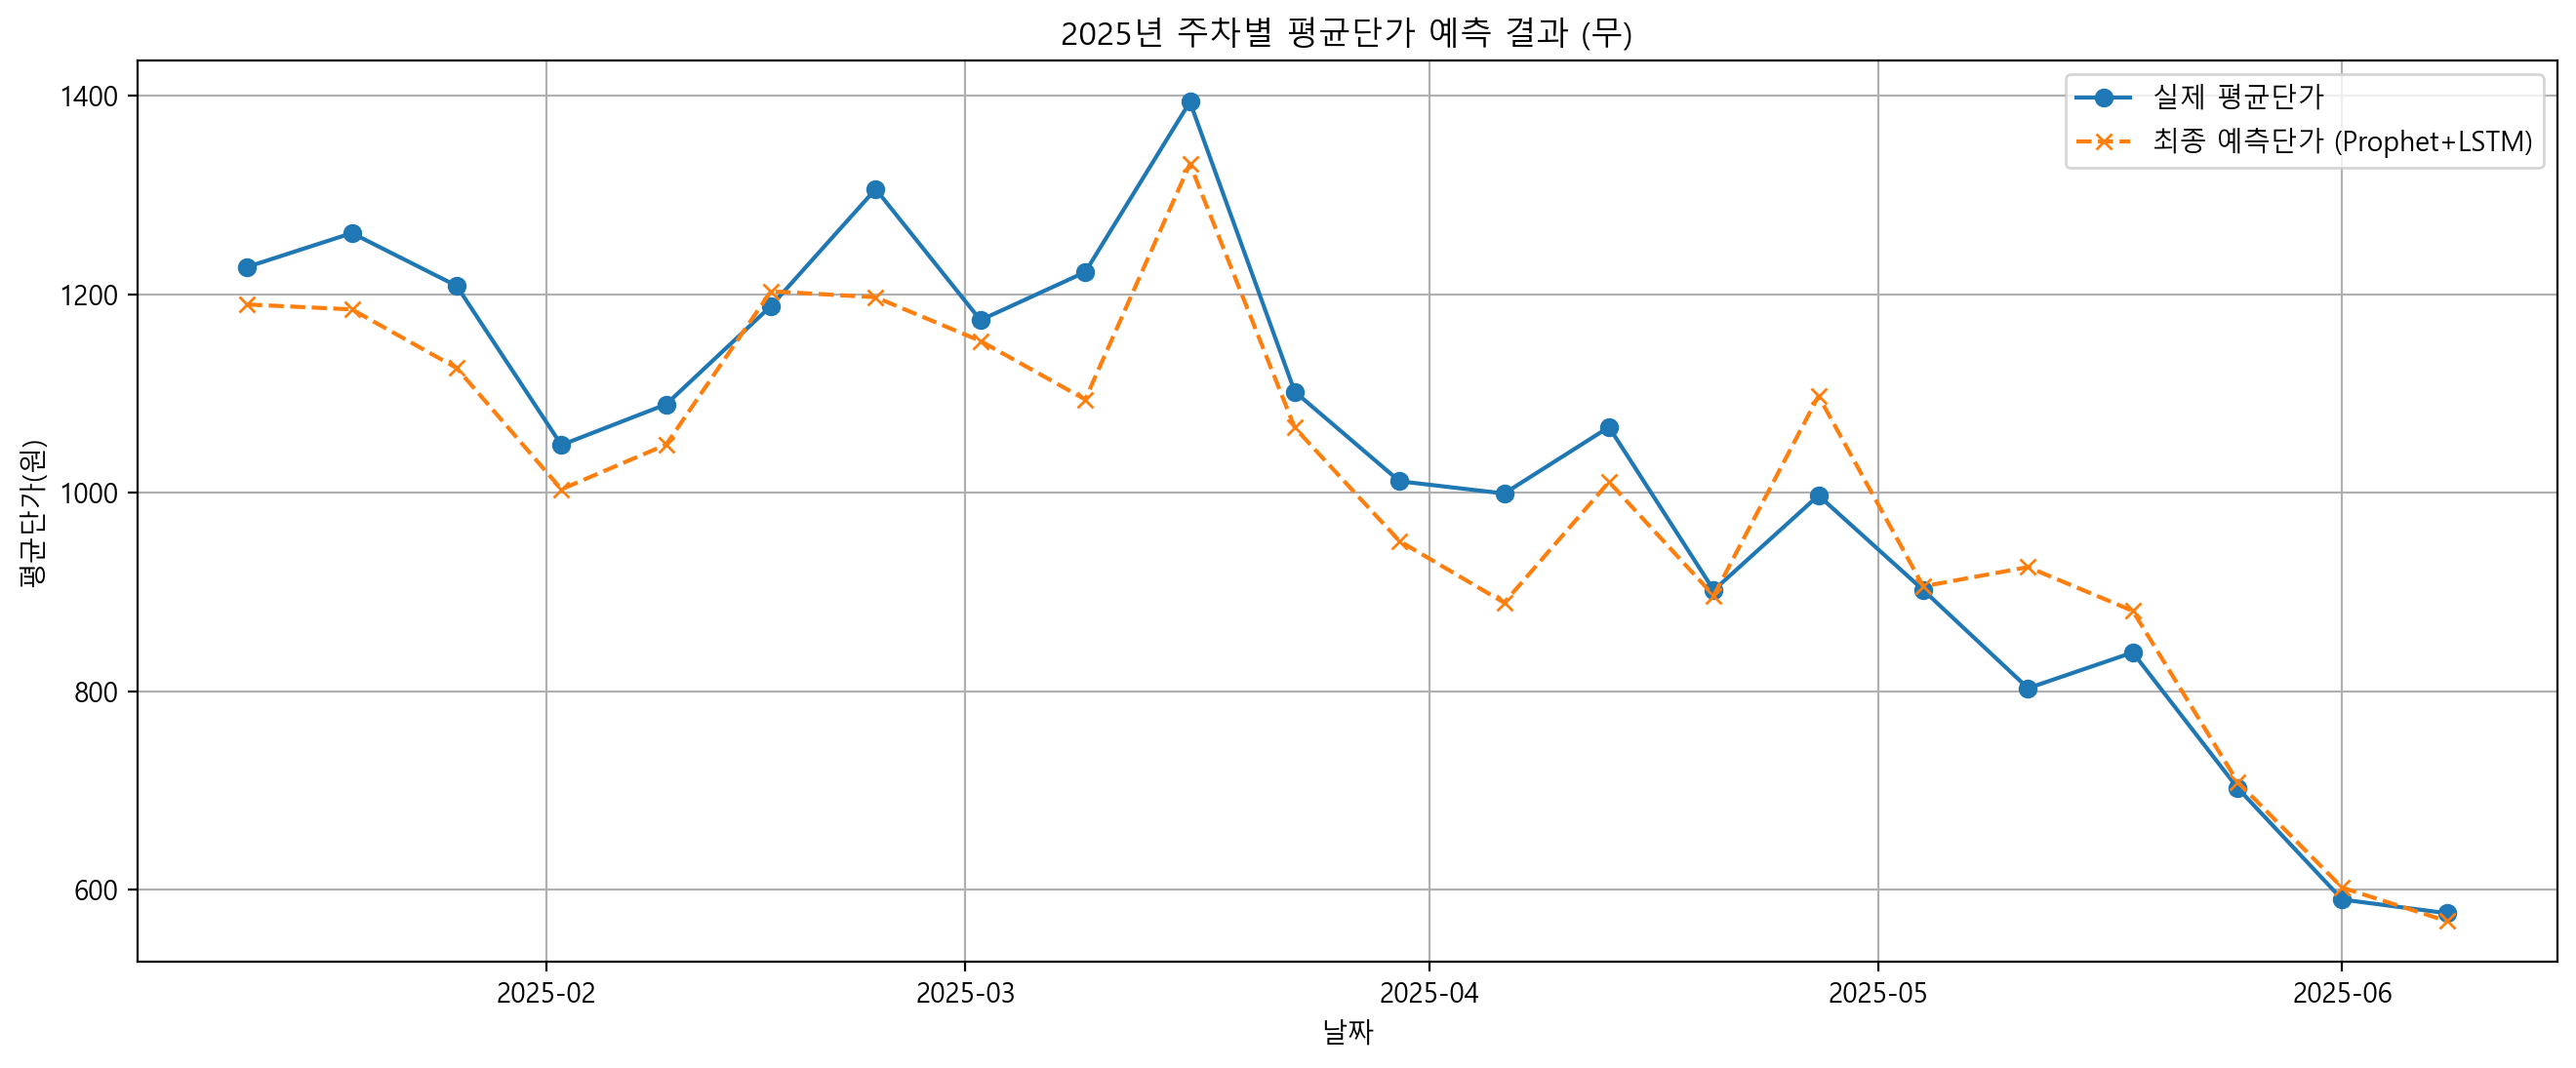

In [32]:
print("\n🚀 최종 예측 및 평가 시작...")
residual_pred_scaled = lstm_model.predict(X_test_seq)
dummy_array = np.zeros((len(residual_pred_scaled), len(lstm_feature_cols)))
dummy_array[:, 0] = residual_pred_scaled.flatten()
residual_pred = scaler.inverse_transform(dummy_array)[:, 0]

prophet_future_pred = test_final_df['prophet_pred'].values[TIMESTEPS:]
final_pred_log = prophet_future_pred + residual_pred

y_original_eval = test_final_df['y_original'].values[TIMESTEPS:]
final_pred_eval = np.expm1(final_pred_log)

mae = mean_absolute_error(y_original_eval, final_pred_eval)
rmse = mean_squared_error(y_original_eval, final_pred_eval, squared=False)
mape = mean_absolute_percentage_error(y_original_eval, final_pred_eval) * 100
nmae = (mae / np.mean(y_original_eval)) * 100
r2 = r2_score(y_original_eval, final_pred_eval)

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

final_model_filename = f'LSTM+Prophet_{item}_MAE_{mae:.0f}_R2_{r2:.4f}_{current_time}.keras'
final_model_path = os.path.join(model_path, final_model_filename)

lstm_model.save(final_model_path)
print("\n" + "="*50)
print(f"   - 파일명: {final_model_filename}")
print(f"   - 경로: {final_model_path}")
print("="*50)

print("="*50)
print(f"MAE (평균 절대 오차):    {mae:.2f} 원")
print(f"RMSE (평균 제곱근 오차): {rmse:.2f} 원")
print(f"MAPE (평균 절대 백분율 오차): {mape:.2f} %")
print(f"NMAE (정규화된 평균 절대 오차): {nmae:.2f} %")
print(f"R² (결정계수):            {r2:.4f}")
print("="*50)


results_df = test_final_df.iloc[TIMESTEPS:].copy()
results_df['final_pred'] = final_pred_eval

results_df = results_df[results_df['year']==2025]

plt.figure(figsize=(16, 6))
plt.plot(results_df['ds'], results_df['y_original'], label='실제 평균단가', marker='o')
plt.plot(results_df['ds'], results_df['final_pred'], label='최종 예측단가 (Prophet+LSTM)', marker='x', linestyle='--')
plt.title(f"{test_final_df['ds'].dt.year.max()}년 주차별 평균단가 예측 결과 ({item})")
plt.xlabel("날짜")
plt.ylabel("평균단가(원)")
plt.legend()
plt.grid(True)
plt.show()